In [1]:
import scipy.integrate as spi
import numpy as np
import pylab as pl
import numpy as np
#import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import integrate
from pylab import *
from scipy.optimize import curve_fit
import numpy as np
from scipy import optimize
import pandas as pd

In [2]:
data = pd.read_csv("../data/dadosCovid.csv")
data.head()

,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
0,Norte,RO,2020-01-30,0,0,0,0
1,Norte,RO,2020-01-31,0,0,0,0
2,Norte,RO,2020-02-01,0,0,0,0
3,Norte,RO,2020-02-02,0,0,0,0
4,Norte,RO,2020-02-03,0,0,0,0


In [3]:
#Select only Sao Paulo
sp = data[data["estado"] == "SP"]
#Remove missing values to not crash the intervals
sp = sp.dropna()
sp.head()

,regiao,estado,data,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
1501,Sudeste,SP,2020-02-26,1,1,0,0
1502,Sudeste,SP,2020-02-27,0,1,0,0
1503,Sudeste,SP,2020-02-28,0,1,0,0
1504,Sudeste,SP,2020-02-29,1,2,0,0
1505,Sudeste,SP,2020-03-01,0,2,0,0


In [4]:
#create a series with the cummulative number of cases
y = np.array(sp["casosAcumulados"])

#Give the number of days since the day of first case confirmed
x = range(0,len(sp["casosAcumulados"]))

In [5]:
# Initial conditions
I0 = 1/50000000
S0= 1 -I0


Time = range(0,len(y))
DayFinal = len(y)

In [6]:
gamma = 1/14

In [7]:
#=EXAMPLE+DEFINING THE Solution of DF-EQ, TRIAL run NEEDS BETA and so on======================================================
def eq(par,initial_cond,start_t,end_t,incr):
    #-time-grid-----------------------------------
    t  = np.linspace(start_t, end_t, num=incr, endpoint=True)
    def funct(y,t):
        S=y[0]
        I=y[1]
        R=y[2]
        beta, gamma = par
        f0 = - beta * S * I        
        f1 = beta * S * I - gamma * I
        f2 = gamma * I
        return [f0, f1, f2]
     #integrate------------------------------------
    ds = integrate.odeint(funct,initial_cond,t)
    return (ds[:,0],ds[:,1],ds[:,2],t)
#=======================================================

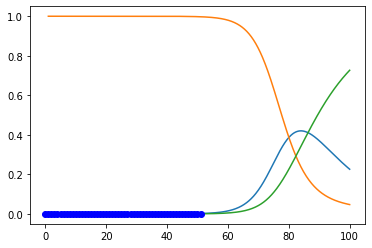

In [8]:
ND=100.0
beta = 0.30
Param=(beta,gamma)
#S0=1-1e-6          # Initial condition need to be defined 
#I0=1e-6
INPUT = [S0, I0, 0.0] # R(0) = 0
         # initial condition vector

Sf, If, Rf, Days = eq(Param,INPUT,1,ND,800)  #1time, steps

pl.plot(Days,If)
pl.plot(Days,Sf)
pl.plot(Days,Rf)
pl.plot(y/50000000, 'ob')
pl.show()

In [9]:
#Fitting of FULL MODEL
def fitFunc(x,beta):
    Param = (beta, gamma)
    INPUT = [S0, I0, 0.0]
    return eq(Param,INPUT,1,DayFinal,DayFinal)[1][x]

p0 = (beta)
popt, pcov = curve_fit(fitFunc, Time, y/50000000, p0)
popt, pcov

(array([0.26044017]), array([[1.31440555e-06]]))

In [10]:
#BOOTSTRAP FITTING!
def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):

    errfunc = lambda p, x, y: function(x,p) - y

    # Fit first time
    pfit, perr = optimize.leastsq(errfunc, p0, args=(datax, datay), full_output=0)


    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)

    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # 100 random data sets are generated and fitted
    rda = []
    ps = []
    for i in range(2000):

        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomdataY = datay + randomDelta

        randomfit, randomcov = \
            optimize.leastsq(errfunc, p0, args=(datax, randomdataY),\
                             full_output=0)
        rda.append(randomdataY)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 2. # 1sigma gets approximately the same as methods above
                # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * np.std(ps,0) 

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    return pfit_bootstrap, perr_bootstrap, sigma_err_total, rda

In [11]:
#COMPARE BOOTSTRAP AND CURVE FIT!
BFIT, BError, sigma_err_total, rda = fit_bootstrap(p0, Time, y/50000000, fitFunc, yerr_systematic=0.0000000)
BFIT, BError, sigma_err_total

(array([0.26039445]), array([0.00196104]), 2.893839973517217e-05)

In [12]:
np.cumsum(np.random.normal(0, sigma_err_total, len(y)) + np.random.normal(0, sigma_err_total, len(y)))

array([ 1.05675039e-05,  3.07023758e-05,  1.13192850e-04,  9.15508130e-05,
        5.49440758e-05, -4.74541397e-05, -6.44695577e-05, -7.72194859e-05,
       -1.35203561e-04, -1.39013998e-04, -1.83615501e-04, -1.98098620e-04,
       -1.74007722e-04, -1.87430737e-04, -8.56608623e-05, -5.76700782e-05,
       -5.04450357e-05, -9.21348476e-05, -1.21506420e-04, -3.02234593e-05,
       -3.06453580e-05, -6.25437312e-05, -5.37717077e-05, -4.33579021e-05,
       -6.82402623e-05, -8.11983466e-05, -9.07133646e-05, -1.60765157e-04,
       -1.94258243e-04, -1.77466067e-04, -1.85259068e-04, -1.74149291e-04,
       -1.19012801e-04, -1.41522288e-04, -1.01110196e-04, -1.45589801e-04,
       -9.75790342e-05, -1.21837857e-04, -1.12617290e-04, -1.15976839e-04,
       -1.54831822e-04, -1.80315751e-04, -2.05941746e-04, -2.45450519e-04,
       -2.74340606e-04, -2.88224642e-04, -3.46318870e-04, -3.51811072e-04,
       -3.98070900e-04, -4.65991996e-04, -4.96831415e-04, -5.38129362e-04])

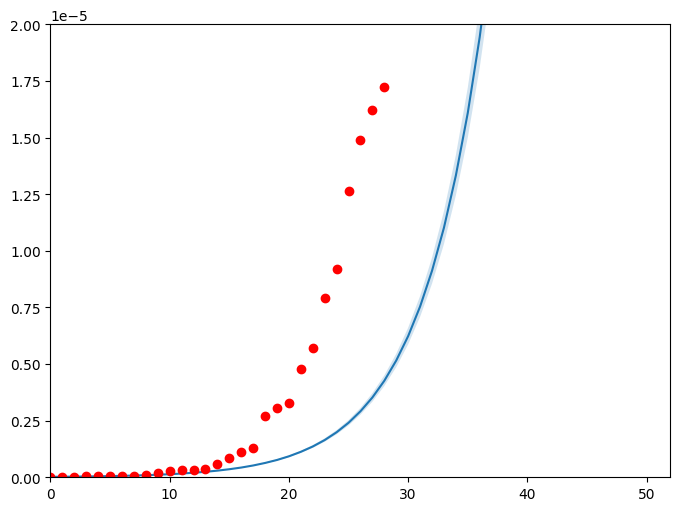

In [13]:
#====PLOTS===================================================
def eq(par,initial_cond,start_t,end_t,incr):
    #-time-grid-----------------------------------
    t  = np.linspace(start_t, end_t, incr)
    def funct(y,t):
        S=y[0]
        I=y[1]
        R=y[2]
        beta, gamma = par
        f0 = - beta * S * I        
        f1 = beta * S * I - gamma * I
        f2 = gamma * I
        return [f0, f1, f2]
     #integrate------------------------------------
    ds = integrate.odeint(funct,initial_cond,t)
    return (ds[:,0],ds[:,1],ds[:,2],t)
#=======================================================
     
#parameters  
#beta= bUp      
gamma=1.0/14.0
#TS=0.1
ND=100.0
Param=(popt[0],gamma)
ParamErr1=(BFIT+BError,gamma)
ParamErr2=(BFIT-BError,gamma)
#S0=1-1e-6          # Initial condition need to be defined 
#I0=1e-6
INPUT = [S0,I0, 0.0] # R(0) = 0
         # initial condition vector

Sf, If, Rf, Days = eq(Param,INPUT,0,ND,101)  #1time, steps
Sf1, If1, Rf1, Days1 = eq(ParamErr1,INPUT,0,ND,101) 
Sf2, If2, Rf2, Days2 = eq(ParamErr2,INPUT,0,ND,101) 

figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
#fig, ax = pl.subplots()
pl.plot(Days,If, '-')
pl.plot(y/50000000, 'or')
pl.fill_between(Days, If1, If2, alpha=0.2)
#pl.errorbar(Time, df_BA, xerr=0.0, yerr=0.0000000, color='r', fmt='o',  ecolor='g',capsize=2,barsabove=True,elinewidth=0.8,)
pl.xlim(0.0,52)
pl.ylim(0,0.00002)
pl.show()